In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
!nvidia-smi
%config InlineBackend.figure_format = 'retina'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
Wed Aug 28 16:11:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   46C    P0    71W / 275W |    497MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [5]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[16:12:25.065] INFO   CaloQVAE                                          Willkommen!
[16:12:25.066] INFO   CaloQVAE                                          Loading configuration.


In [6]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
# from utils.plotting import HighLevelFeatures as HLF
# HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
# HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
# HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2024-08-28 16:12:26,249 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[16:12:26.249] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [7]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [8]:
# run_path= "/home/javier/Projects/CaloQVAE/outputs/2024-07-18/18-22-00/wandb/run-20240718_182201-5q976hf7/files/AtlasConditionalQVAE_atlas_default_best.pth"
# fn = create_filenames_dict(run_path)

In [8]:

# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")

HLF_1_photons = HLF('photon', filename=config.data.binning_xml_photons, wandb=False)
HLF_1_pions = HLF('pion', filename=config.data.binning_xml_pions, wandb=False)
HLF_1_electron = HLF('electron', filename=config.data.binning_xml_electrons, wandb=False)

wandb.init(project="caloqvae", entity=config.data.entity, config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[16:12:33.436] INFO   data.dataManager                                  Loading Data
[16:12:55.055] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f6a4a27d890>: 80000 events, 625 batches
[16:12:55.056] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f6a4a287ed0>: 10000 events, 10 batches
[16:12:55.057] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f6a4a29fad0>: 10000 events, 10 batches
[16:12:57.221] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAE3D
2024-08-28 16:12

Initializing NetworkV3


In [9]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[16:13:00.747] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[16:13:01.110] INFO   engine.engineAtlas                                Setting up engine Atlas.
[16:13:01.111] INFO   engine.engineCaloV3                               Setting up engine Calo.
[16:13:01.111] INFO   engine.engine                                     Setting up default engine.


In [10]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[16:13:22.424] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f69647bf010>: 80000 events, 625 batches
[16:13:22.425] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f695d7c7910>: 10000 events, 10 batches
[16:13:22.425] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f695c17aa10>: 10000 events, 10 batches


In [11]:
engine.model._qpu_sampler.properties["chip_id"]

'Advantage_system6.4'

In [14]:

    



#morning-bush-469 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-05-50/wandb/run-20240624_200551-lejg0j91/files/AtlasConditionalQVAE_atlas_default_150.pth"
modelname = 'morning-bush-469'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-05-50/wandb/run-20240624_200551-lejg0j91/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    cond = True
    
    
# #flowing-energy-471 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 0.005
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-36-20/wandb/run-20240627_143621-t4xwn93t/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'flowing-energy-471'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-36-20/wandb/run-20240627_143621-t4xwn93t/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True
    
    
# #crisp-wildflower-472 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-39-50/wandb/run-20240627_143952-x09rgjmp/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'crisp-wildflower-472'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-39-50/wandb/run-20240627_143952-x09rgjmp/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True
    
# #peachy-elevator-473 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-42-27/wandb/run-20240627_144228-4sttgocs/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'peachy-elevator-473'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-42-27/wandb/run-20240627_144228-4sttgocs/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = False


# #resilient-surf-478 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/AtlasConditionalQVAE_atlas_default_130.pth"
# modelname = 'resilient-surf-478'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True
    

# #earnest-frost-483 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-07-18/18-22-00/wandb/run-20240721_142426-5q976hf7/files/AtlasConditionalQVAE_atlas_default_latest.pth"
# modelname = 'earnest-frost-483'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True
    
# #stellar-terrain-484 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-07-21/15-00-55/wandb/run-20240723_132510-ycmoh4pu/files/AtlasConditionalQVAE_atlas_default_120.pth"
# modelname = 'stellar-terrain-484'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True

    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata, R)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[17:19:16.602] INFO   models.modelCreator                               Loading state
[17:19:16.710] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-05-50/wandb/run-20240624_200551-lejg0j91/files/AtlasConditionalQVAE_atlas_default_150.pth


AtlasConditionalQVAE
electron-ds2
False True 1e-07
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [22]:
import jetnet
import re

def extract_shower_and_energy(given_file, which):
    """ reads .hdf5 file and returns samples and their energy """
    print("Extracting showers from {} file ...".format(which))
    if which == 0.:
        shower = given_file['showers'][:]
        energy = given_file['incident_energies'][:]
    else:
        shower = given_file['showers'][:]
        energy = given_file['incidence energy'][:]
    print("Extracting showers from {} file: DONE.\n".format(which))
    return shower, energy

def prepare_high_data_for_classifier(test, e_inc, hlf_class, label):
    """ takes hdf5_file, extracts high-level features, appends label, returns array """
    # voxel, E_inc = extract_shower_and_energy(hdf5_file, label)
    voxel, E_inc = test, e_inc
    E_tot = hlf_class.GetEtot()
    E_layer = []
    for layer_id in hlf_class.GetElayers():
        E_layer.append(hlf_class.GetElayers()[layer_id].reshape(-1, 1))
    EC_etas = []
    EC_phis = []
    Width_etas = []
    Width_phis = []
    for layer_id in hlf_class.layersBinnedInAlpha:
        EC_etas.append(hlf_class.GetECEtas()[layer_id].reshape(-1, 1))
        EC_phis.append(hlf_class.GetECPhis()[layer_id].reshape(-1, 1))
        Width_etas.append(hlf_class.GetWidthEtas()[layer_id].reshape(-1, 1))
        Width_phis.append(hlf_class.GetWidthPhis()[layer_id].reshape(-1, 1))
    E_layer = np.concatenate(E_layer, axis=1)
    EC_etas = np.concatenate(EC_etas, axis=1)
    EC_phis = np.concatenate(EC_phis, axis=1)
    Width_etas = np.concatenate(Width_etas, axis=1)
    Width_phis = np.concatenate(Width_phis, axis=1)
    ret = np.concatenate([np.log10(E_inc), np.log10(E_layer+1e-8), EC_etas/1e2, EC_phis/1e2,
                          Width_etas/1e2, Width_phis/1e2, label*np.ones_like(E_inc)], axis=1)
    return ret

def check_and_replace_nans_infs(data):
    if np.isnan(data).any() or np.isinf(data).any():
        print("Data contains NaNs or Infs. Handling them...")
        # Replace NaNs and Infs with zeros (or you can choose a different strategy)
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    return data

def get_fpd_kpd_metrics(test_data, gen_data, syn_bool, hlf, ref_hlf):
    print("TESTING HELLO")
    if syn_bool == True:
        data_showers = (np.array(test_data['showers']))
        energy = (np.array(test_data['incident_energies']))
        gen_showers = (np.array(gen_data['showers'], dtype=float))
        hlf.Einc = energy
    else:
        data_showers = test_data
        gen_showers = gen_data
    hlf.CalculateFeatures(data_showers)
    ref_hlf.CalculateFeatures(gen_showers)
    hlf_test_data = prepare_high_data_for_classifier(test_data, hlf.Einc, hlf, 0.)[:, :-1]
    hlf_gen_data = prepare_high_data_for_classifier(gen_data, hlf.Einc, ref_hlf, 1.)[:, :-1]
    hlf_test_data = check_and_replace_nans_infs(hlf_test_data)
    hlf_gen_data = check_and_replace_nans_infs(hlf_gen_data)
    fpd_val, fpd_err = jetnet.evaluation.fpd(hlf_test_data, hlf_gen_data)
    kpd_val, kpd_err = jetnet.evaluation.kpd(hlf_test_data, hlf_gen_data)
    
    result_str = (
        f"FPD (x10^3): {fpd_val*1e3:.4f} ± {fpd_err*1e3:.4f}\n" 
        f"KPD (x10^3): {kpd_val*1e3:.4f} ± {kpd_err*1e3:.4f}"
    )
    
    print(result_str)
    return fpd_val, fpd_err, kpd_val, kpd_err


def search_HEPMetric(run_path, engine, dev, step = 10, data="caloqvae"):
    fn = create_filenames_dict(run_path, data)
    en_list = []
    fpd_recon, fpd_sample = [], []
    kpd_recon, kpd_sample = [], []
    hlf, ref_hlf = None, None
    
    R = engine._config.engine.r_param
    reducedata = engine._config.reducedata
    scaled=engine._config.data.scaled
    
    for i in range(step,(1+fn["size"])*step,step):

        _right_dir = get_right_dir(i, fn)
        # _pattern = get_right_pattern(i, fn)
        model_path = fn["prefix"] + "/" + _right_dir + '/files/'
        # modelCreator.load_state(model_path + get_right_pattern(i, fn), dev)
        full_path = model_path + get_right_pattern(i, fn)
        logger.info(f'Loading model {full_path}')
        engine.model_creator.load_state(full_path, dev)
        engine.model.eval();
        
        # get the samples
        xtarget_samples = []
        xrecon_samples = []
        xgen_samples = []
        xgen_samples_qpu = []
        n_samples4_qpu = 200
        entarget_samples = []
        for data_loader in [val_loader,test_loader]: #, train_loader]:
            arr = gen_synth_data(engine, R, reducedata, data_loader)
            xtarget_samples.append(arr[0])
            xrecon_samples.append(arr[1])
            xgen_samples.append(arr[2])
            entarget_samples.append(arr[3])
            
            
        xtarget_samples = torch.cat(xtarget_samples, dim=0)
        xrecon_samples = torch.cat(xrecon_samples, dim=0)
        xgen_samples = torch.cat(xgen_samples, dim=0)
        # xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
        entarget_samples = torch.cat(entarget_samples, dim=0)
        
        # xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)
        if i == step:
            logger.info("First epoch")
            hlf = HLF('electron', filename=engine._config.data.binning_xml_electrons, wandb=False)
            ref_hlf = HLF('electron', filename=engine._config.data.binning_xml_electrons, wandb=False)
            hlf.Einc = entarget_samples
    
        recon_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xrecon_samples), False, hlf, ref_hlf)
        sample_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xgen_samples), False, hlf, ref_hlf)

        en_list.append(i)
        fpd_recon.append(recon_HEPMetrics[0])
        kpd_recon.append(recon_HEPMetrics[2])
        fpd_sample.append(sample_HEPMetrics[0])
        kpd_sample.append(sample_HEPMetrics[2])
        logger.info("Finished generating HEP Metrics for epoch " + str(i) + " ...")
    return en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample

def gen_synth_data(engine, R, reducedata, data_loader):
    xtarget_samples = []
    xrecon_samples = []
    xgen_samples = []
    xgen_samples_qpu = []
    entarget_samples = []
    
    with torch.no_grad():
        for xx in data_loader:
            in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
            ###############################################
            # true_energy = true_energy[:n_samples4_qpu,:]
            # in_data = in_data[:n_samples4_qpu,:]
            ##############################################
            # print(in_data.shape)
            if reducedata:
                in_data = engine._reduce(in_data, true_energy, R=R)
            fwd_output = engine.model((in_data, true_energy), False)
            if reducedata:
                in_data = engine._reduceinv(in_data, true_energy, R=R)
                recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                engine._model.sampler._batch_size = true_energy.shape[0]
                if True:
                    sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                    # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                else:
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                    # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
            elif scaled:
                in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                engine._model.sampler._batch_size = true_energy.shape[0]

                if True:
                    sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                    # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                else:
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                    # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
            else:
                in_data = in_data.detach().cpu()*1000
                recon_data = fwd_output.output_activations.detach().cpu()*1000
                engine._model.sampler._batch_size = true_energy.shape[0]
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                sample_data = sample_data.detach().cpu()*1000


            xtarget_samples.append(in_data.detach().cpu())
            xrecon_samples.append( recon_data.detach().cpu())
            xgen_samples.append( sample_data.detach().cpu())
            # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
            entarget_samples.append(true_energy.detach().cpu())
            
        xtarget_samples = torch.cat(xtarget_samples, dim=0)
        xrecon_samples = torch.cat(xrecon_samples, dim=0)
        xgen_samples = torch.cat(xgen_samples, dim=0)
        # xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
        entarget_samples = torch.cat(entarget_samples, dim=0)


    return xtarget_samples, xrecon_samples, xgen_samples, entarget_samples



def save_plot(HEPMetric_output, run_path):
    path = run_path.split('files')[0] + 'files/'
    en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot fpd_recon and fpd_sample on ax1
    ax1.scatter(en_list, fpd_recon, color='blue', label='FPD Recon')
    ax1.scatter(en_list, fpd_sample, color='green', label='FPD Sample')
    ax1.set_xlabel('Epoch Number')
    ax1.set_ylabel('FPD Values')
    ax1.set_title('FPD Recon vs FPD Sample')
    ax1.legend()

    # Plot kpd_recon and kpd_sample on ax2
    ax2.scatter(en_list, kpd_recon, color='blue', label='KPD Recon')
    ax2.scatter(en_list, kpd_sample, color='green', label='KPD Sample')
    ax2.set_xlabel('Epoch Number')
    ax2.set_ylabel('KPD Values')
    ax2.set_title('KPD Recon vs KPD Sample')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(path + f'KPD_and_FPD.png')
    plt.show()
    
    np.savez(path + 'JetData.npz', array1=en_list, array2=fpd_recon, array3=kpd_recon, array4=fpd_sample, array5=kpd_sample)

def create_filenames_dict(run_path, data="caloqvae"):
    pattern = r'\d+.pth$'
    if data=="caloqvae":
        filenames = {}
        file = run_path.split("/")[-3]
        # filenames[file] = list(np.sort(os.listdir(run_path.split("files")[0] + f'files/RBM/')))
        fn_ = list(np.sort(os.listdir(run_path.split("wandb")[0] + f'wandb/{file}/files/')))
        filenames[file] = [word for word in fn_ if re.search(pattern, word)]
        filenames["size"] = int(len(filenames[file]))
        # filenames["prefix"] = run_path.split("outputs_sym")[0] + "outputs_sym"
        filenames["prefix"] = run_path.split("wandb")[0] + "wandb"
    else:
        filenames = {}
        files = os.listdir(run_path.split("wandb")[0] + "wandb")
        trueInd = [ "run" in file for file in files]
        for i, file in enumerate(files):
            if trueInd[i] and "latest" not in file:
                try:
                    fn_ = list(np.sort(os.listdir(run_path.split("wandb")[0] + f'wandb/{file}/files/')))
                    # filenames[file] = [word for word in fn_ if word.endswith('pth')]
                    filenames[file] = [word for word in fn_ if re.search(pattern, word)]
                    
                    
                except:
                    logger.warning(f'Directory {run_path.split("wandb")[0]}' + f'wandb/{file}/files/ might not exist.')


        list_of_files = []
        for key in filenames.keys():
            list_of_files = list_of_files + filenames[key]
        filenames["size"] = int(len(list_of_files))
        filenames["prefix"] = run_path.split("wandb")[0] + "wandb"
        filenames = {key: value for key, value in filenames.items() if value}
    return filenames

def get_right_dir(i, filenames):
    pattern = get_right_pattern(i, filenames)
    logger.info(f'Model {pattern}')
    
    for key in filenames.keys():
        # if f'RBM_{i}_9_weights.pth' in filenames[key]:
        if pattern in filenames[key]:
            _right_dir = key
            break
    return _right_dir

def get_right_pattern(i, filenames):
    first_key = list(filenames)[0]
    pattern = filenames[first_key][-1].split('default_')[0] + f'default_{i}.pth'
    return pattern

In [19]:
HEPMetric_output = search_HEPMetric(config.run_path, engine, dev, 10, config.data.entity)

[16:27:03.502] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_10.pth
[16:27:03.503] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_10.pth
[16:27:03.503] INFO   models.modelCreator                               Loading state
[16:27:03.628] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_10.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


[16:27:45.677] INFO   __main__                                          First epoch


TESTING HELLO
Data contains NaNs or Infs. Handling them...


/tmp/ipykernel_764054/607297810.py:65: RuntimeWarning: Recommended number of samples for FPD estimation is 50,000
  fpd_val, fpd_err = jetnet.evaluation.fpd(hlf_test_data, hlf_gen_data)


FPD (x10^3): 573.2905 ± 4.3021
KPD (x10^3): 2.5127 ± 0.5862
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:29:26.639] INFO   __main__                                          Finished generating HEP Metrics for epoch 10 ...
[16:29:26.640] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_20.pth
[16:29:26.641] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_20.pth
[16:29:26.641] INFO   models.modelCreator                               Loading state
[16:29:26.824] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_20.pth


FPD (x10^3): 654.4677 ± 5.2418
KPD (x10^3): 3.1386 ± 0.6490
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 530.6422 ± 4.9659
KPD (x10^3): 2.9567 ± 0.5901
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:32:18.120] INFO   __main__                                          Finished generating HEP Metrics for epoch 20 ...
[16:32:18.121] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_30.pth
[16:32:18.122] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_30.pth
[16:32:18.122] INFO   models.modelCreator                               Loading state
[16:32:18.260] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_30.pth


FPD (x10^3): 750.8064 ± 4.9185
KPD (x10^3): 5.1446 ± 0.7991
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 422.6897 ± 3.2850
KPD (x10^3): 1.5657 ± 0.3620
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:34:55.733] INFO   __main__                                          Finished generating HEP Metrics for epoch 30 ...
[16:34:55.735] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_40.pth
[16:34:55.735] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_40.pth
[16:34:55.735] INFO   models.modelCreator                               Loading state
[16:34:55.870] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_40.pth


FPD (x10^3): 549.3405 ± 3.1887
KPD (x10^3): 2.0221 ± 0.4280
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 434.3821 ± 3.9525
KPD (x10^3): 2.4406 ± 0.6090
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:37:41.237] INFO   __main__                                          Finished generating HEP Metrics for epoch 40 ...
[16:37:41.239] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_50.pth
[16:37:41.239] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_50.pth
[16:37:41.239] INFO   models.modelCreator                               Loading state
[16:37:41.389] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_50.pth


FPD (x10^3): 572.5135 ± 4.7420
KPD (x10^3): 2.8841 ± 0.6429
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 384.4026 ± 2.8658
KPD (x10^3): 1.2549 ± 0.2741
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:40:26.042] INFO   __main__                                          Finished generating HEP Metrics for epoch 50 ...
[16:40:26.044] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_60.pth
[16:40:26.044] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_60.pth
[16:40:26.044] INFO   models.modelCreator                               Loading state
[16:40:26.149] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_60.pth


FPD (x10^3): 557.4174 ± 3.7635
KPD (x10^3): 2.0559 ± 0.4268
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 364.0018 ± 2.2160
KPD (x10^3): 1.3147 ± 0.3210
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:43:12.883] INFO   __main__                                          Finished generating HEP Metrics for epoch 60 ...
[16:43:12.886] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_70.pth
[16:43:12.886] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_70.pth
[16:43:12.886] INFO   models.modelCreator                               Loading state
[16:43:13.021] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240816_183755-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_70.pth


FPD (x10^3): 573.8477 ± 3.6812
KPD (x10^3): 1.5369 ± 0.3460
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 414.0984 ± 4.0112
KPD (x10^3): 2.2978 ± 0.5606
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:45:51.625] INFO   __main__                                          Finished generating HEP Metrics for epoch 70 ...
[16:45:51.626] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_80.pth
[16:45:51.626] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_80.pth
[16:45:51.626] INFO   models.modelCreator                               Loading state
[16:45:51.763] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_80.pth


FPD (x10^3): 667.8977 ± 5.1512
KPD (x10^3): 3.0933 ± 0.6181
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 348.8287 ± 2.9331
KPD (x10^3): 1.1621 ± 0.4080
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:48:29.218] INFO   __main__                                          Finished generating HEP Metrics for epoch 80 ...
[16:48:29.219] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_90.pth
[16:48:29.220] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_90.pth
[16:48:29.220] INFO   models.modelCreator                               Loading state
[16:48:29.373] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_90.pth


FPD (x10^3): 506.1129 ± 2.9332
KPD (x10^3): 1.3016 ± 0.2215
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 328.7731 ± 2.6584
KPD (x10^3): 0.9942 ± 0.2437
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:51:13.056] INFO   __main__                                          Finished generating HEP Metrics for epoch 90 ...
[16:51:13.057] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_100.pth
[16:51:13.058] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_100.pth
[16:51:13.058] INFO   models.modelCreator                               Loading state
[16:51:13.202] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_100.pth


FPD (x10^3): 496.0584 ± 2.8483
KPD (x10^3): 1.1905 ± 0.2873
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 312.3596 ± 2.1699
KPD (x10^3): 0.8000 ± 0.1725
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:54:23.384] INFO   __main__                                          Finished generating HEP Metrics for epoch 100 ...
[16:54:23.385] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_110.pth
[16:54:23.386] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_110.pth
[16:54:23.386] INFO   models.modelCreator                               Loading state
[16:54:23.472] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_110.pth


FPD (x10^3): 470.8339 ± 2.5942
KPD (x10^3): 0.9823 ± 0.1346
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 328.4993 ± 3.1252
KPD (x10^3): 1.3847 ± 0.3764
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:56:53.706] INFO   __main__                                          Finished generating HEP Metrics for epoch 110 ...
[16:56:53.707] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_120.pth
[16:56:53.708] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_120.pth
[16:56:53.708] INFO   models.modelCreator                               Loading state
[16:56:53.848] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_120.pth


FPD (x10^3): 502.6097 ± 3.8202
KPD (x10^3): 1.8283 ± 0.4452
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 314.9148 ± 2.1536
KPD (x10^3): 0.8716 ± 0.2659
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[16:59:43.811] INFO   __main__                                          Finished generating HEP Metrics for epoch 120 ...
[16:59:43.814] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_130.pth
[16:59:43.814] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_130.pth
[16:59:43.814] INFO   models.modelCreator                               Loading state
[16:59:43.964] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_130.pth


FPD (x10^3): 474.9874 ± 2.7342
KPD (x10^3): 1.1259 ± 0.2181
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 329.5836 ± 3.2899
KPD (x10^3): 1.3024 ± 0.4431
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:02:35.206] INFO   __main__                                          Finished generating HEP Metrics for epoch 130 ...
[17:02:35.207] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_140.pth
[17:02:35.208] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_140.pth
[17:02:35.208] INFO   models.modelCreator                               Loading state
[17:02:35.344] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_140.pth


FPD (x10^3): 551.8621 ± 3.3144
KPD (x10^3): 2.4741 ± 0.5611
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 307.1666 ± 2.1208
KPD (x10^3): 0.8338 ± 0.2320
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:05:21.556] INFO   __main__                                          Finished generating HEP Metrics for epoch 140 ...
[17:05:21.557] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_150.pth
[17:05:21.557] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_150.pth
[17:05:21.557] INFO   models.modelCreator                               Loading state
[17:05:21.697] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_150.pth


FPD (x10^3): 488.3155 ± 2.8230
KPD (x10^3): 1.1352 ± 0.1121
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 311.0756 ± 2.2682
KPD (x10^3): 0.8051 ± 0.2266
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:08:07.700] INFO   __main__                                          Finished generating HEP Metrics for epoch 150 ...
[17:08:07.702] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_160.pth
[17:08:07.702] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_160.pth
[17:08:07.702] INFO   models.modelCreator                               Loading state
[17:08:07.833] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_160.pth


FPD (x10^3): 504.8875 ± 3.0930
KPD (x10^3): 0.9615 ± 0.1608
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 326.7067 ± 3.1188
KPD (x10^3): 1.1848 ± 0.3581
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:10:53.152] INFO   __main__                                          Finished generating HEP Metrics for epoch 160 ...
[17:10:53.153] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_170.pth
[17:10:53.153] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_170.pth
[17:10:53.154] INFO   models.modelCreator                               Loading state
[17:10:53.289] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_170.pth


FPD (x10^3): 502.3351 ± 2.9796
KPD (x10^3): 1.0789 ± 0.2500
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 316.6687 ± 2.7414
KPD (x10^3): 0.9451 ± 0.2993
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:13:42.112] INFO   __main__                                          Finished generating HEP Metrics for epoch 170 ...
[17:13:42.113] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_180.pth
[17:13:42.114] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_180.pth
[17:13:42.114] INFO   models.modelCreator                               Loading state
[17:13:42.252] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_180.pth


FPD (x10^3): 493.3431 ± 2.7844
KPD (x10^3): 1.0495 ± 0.1917
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 325.6878 ± 2.9738
KPD (x10^3): 1.1357 ± 0.3710
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:16:24.424] INFO   __main__                                          Finished generating HEP Metrics for epoch 180 ...
[17:16:24.425] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_190.pth
[17:16:24.425] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_190.pth
[17:16:24.426] INFO   models.modelCreator                               Loading state
[17:16:24.560] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_190.pth


FPD (x10^3): 496.5752 ± 3.2581
KPD (x10^3): 1.0182 ± 0.2363
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 323.5886 ± 3.0340
KPD (x10^3): 1.1671 ± 0.3634
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:19:30.976] INFO   __main__                                          Finished generating HEP Metrics for epoch 190 ...
[17:19:30.978] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_200.pth
[17:19:30.978] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_200.pth
[17:19:30.979] INFO   models.modelCreator                               Loading state
[17:19:31.048] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_200.pth


FPD (x10^3): 498.5052 ± 3.4057
KPD (x10^3): 1.0568 ± 0.2396
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 320.0293 ± 2.9014
KPD (x10^3): 1.1020 ± 0.3428
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:21:56.297] INFO   __main__                                          Finished generating HEP Metrics for epoch 200 ...
[17:21:56.298] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_210.pth
[17:21:56.299] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_210.pth
[17:21:56.299] INFO   models.modelCreator                               Loading state
[17:21:56.442] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_210.pth


FPD (x10^3): 499.4444 ± 3.3104
KPD (x10^3): 1.0535 ± 0.1913
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 326.1752 ± 2.8467
KPD (x10^3): 1.2204 ± 0.3853
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:24:42.394] INFO   __main__                                          Finished generating HEP Metrics for epoch 210 ...
[17:24:42.395] INFO   __main__                                          Model AtlasConditionalQVAE3D_atlas_default_220.pth
[17:24:42.395] INFO   __main__                                          Loading model /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_220.pth
[17:24:42.396] INFO   models.modelCreator                               Loading state
[17:24:42.536] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240826_133632-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_220.pth


FPD (x10^3): 494.2036 ± 3.0397
KPD (x10^3): 1.0441 ± 0.2244
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 314.7802 ± 2.8340
KPD (x10^3): 0.9885 ± 0.2786
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[17:27:30.637] INFO   __main__                                          Finished generating HEP Metrics for epoch 220 ...


FPD (x10^3): 498.8375 ± 2.8181
KPD (x10^3): 1.0355 ± 0.1723


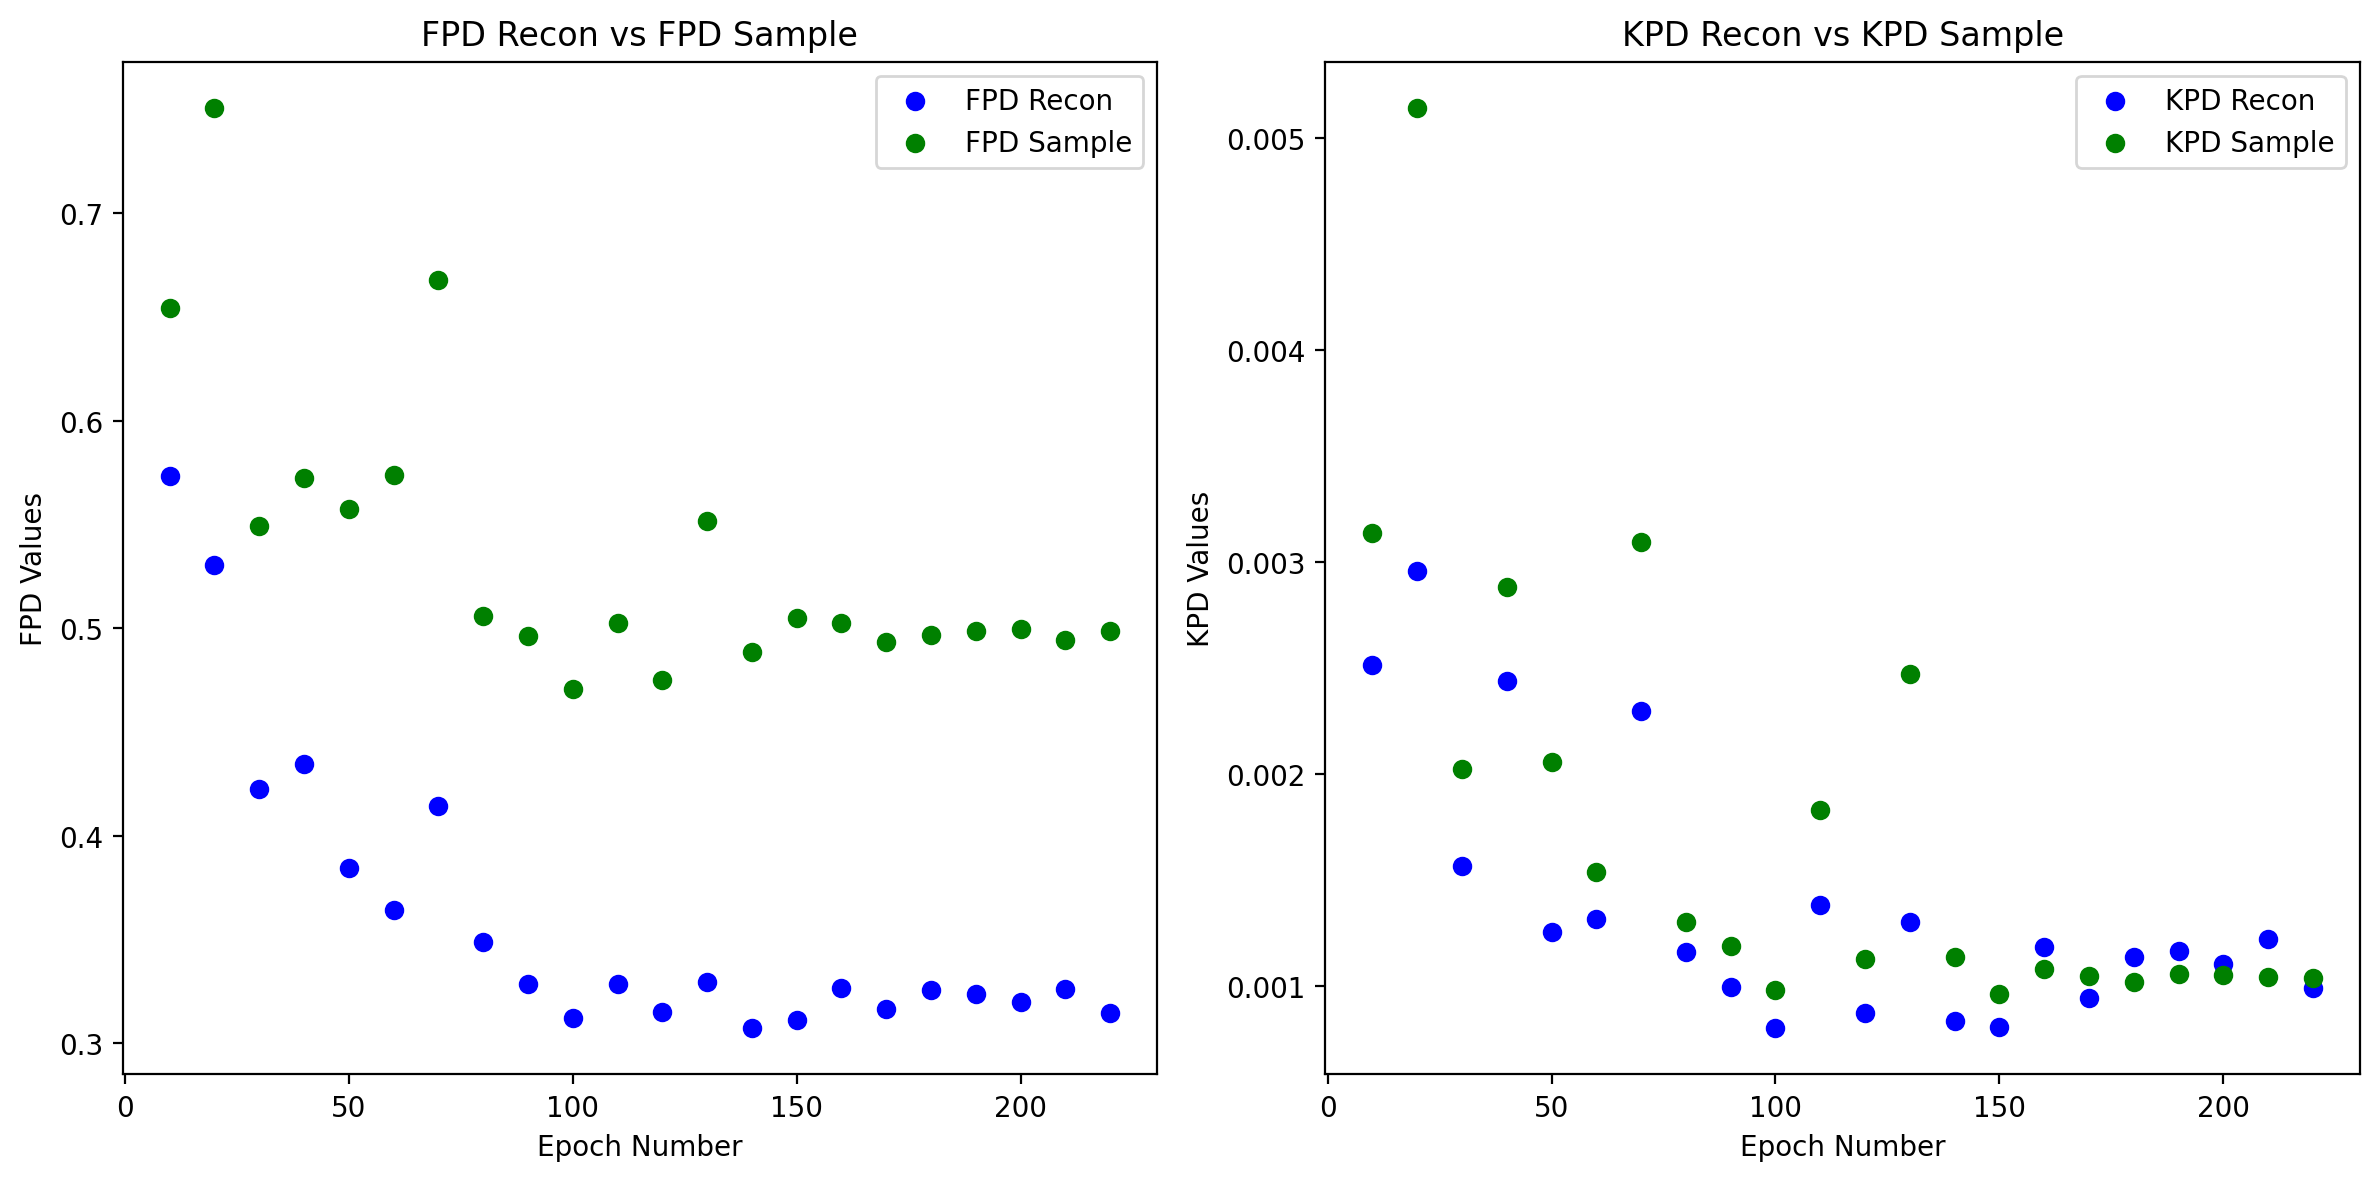

In [23]:
save_plot(HEPMetric_output, config.run_path)

In [21]:
config.run_path

'/home/javier/Projects/CaloQVAE/outputs/2024-08-16/18-37-54/wandb/run-20240818_130637-frfzrs9j/files/AtlasConditionalQVAE3D_atlas_default_140.pth'

In [47]:
# HEPMetric_output
# get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xrecon_samples), False, hlf, ref_hlf)
HEPMetric_output[4]

In [15]:
get_fpd_kpd_metrics(HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4])

TESTING HELLO
Data contains NaNs or Infs. Handling them...


/tmp/ipykernel_764054/3450954175.py:65: RuntimeWarning: Recommended number of samples for FPD estimation is 50,000
  fpd_val, fpd_err = jetnet.evaluation.fpd(hlf_test_data, hlf_gen_data)


FPD (x10^3): 574.2779 ± 4.2280
KPD (x10^3): 2.4953 ± 0.6055


(0.5742779016416081,
 0.004227988531820257,
 0.0024953117467401142,
 0.0006054614188105096)

In [74]:
HLF.HighLevelFeatures('electron', filename=engine._config.data.binning_xml_electrons, wandb=False)

In [75]:
data_showers = HEPMetric_output[0]
gen_showers = HEPMetric_output[1]
hlf = HLF.HighLevelFeatures('electron', filename=engine._config.data.binning_xml_electrons, wandb=False)
ref_hlf = HEPMetric_output[4]

hlf.CalculateFeatures(data_showers)
ref_hlf.CalculateFeatures(gen_showers)
# hlf_test_data = prepare_high_data_for_classifier(test_data, hlf.Einc, hlf, 0.)[:, :-1]
# hlf_gen_data = prepare_high_data_for_classifier(gen_data, hlf.Einc, ref_hlf, 1.)[:, :-1]
# hlf_test_data = check_and_replace_nans_infs(hlf_test_data)
# hlf_gen_data = check_and_replace_nans_infs(hlf_gen_data)
# fpd_val, fpd_err = jetnet.evaluation.fpd(hlf_test_data, hlf_gen_data)
# kpd_val, kpd_err = jetnet.evaluation.kpd(hlf_test_data, hlf_gen_data)